# Challenge Description 

We got employee data from a few companies. We have data about all employees who joined
from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the
company as of 2015/12/13 or they have quit. Beside that, we have general info about the
employee, such as avg salary during her tenure, dept, and yrs of experience.

### Our Goal

1. Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.
2. What are the main factors that drive employee churn? Do they make sense? Explain your
findings.
3. If you could add to this data set just one variable that could help explain employee churn,
what would that be?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn as sk
# from sklearn.metric
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('day3.csv',parse_dates = ['join_date','quit_date'])
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [3]:
data.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [4]:
data.info()
#data type is correct

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null datetime64[ns]
quit_date      13510 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [5]:
len(data.employee_id) == len(data.employee_id.unique())
# shows no duplicate employees

True

In [6]:
data.isnull().sum()
# some of quit_date is null, means they haven't left company yet on the last date.

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

### Data Cleaning

In [7]:
# create a dataframe with 3 columns: day, employee_headcount, company_id
res_date = pd.date_range(start = '2011-01-25', end = '2015-12-13',freq = 'D')
res_company = sorted(data['company_id'].unique())

In [8]:
hc_list = []
date_list = []
company_list = []
for date in res_date:
    for company in res_company:
        headcount = len(data[(data['join_date']<= date) & (data['quit_date']>=date) & (data['company_id'] == company )])
        date_list.append(date)
        company_list.append(company)
        hc_list.append(headcount)

In [9]:
emp_stat = pd.DataFrame(list(zip(date_list,company_list,hc_list)),columns = ['day','company_id','employee_headcount'])
emp_stat.head(5)

,day,company_id,employee_headcount
0,2011-01-25,1,27
1,2011-01-25,2,19
2,2011-01-25,3,10
3,2011-01-25,4,12
4,2011-01-25,5,5


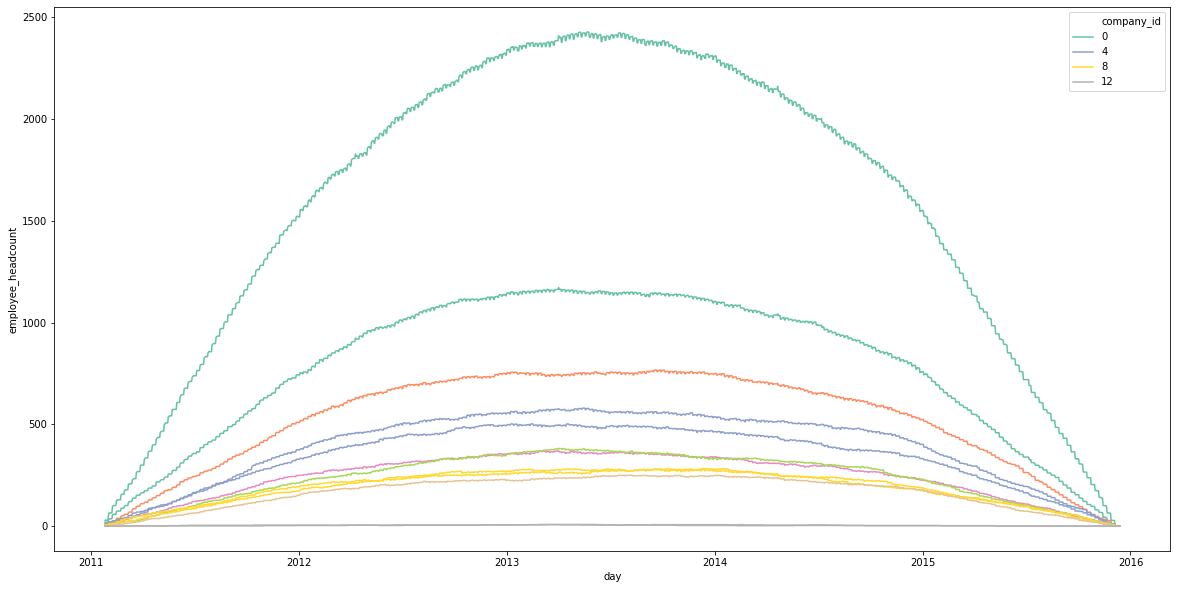

In [34]:
# show the headcount changes of each company
fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(x="day", y="employee_headcount",hue="company_id", data=emp_stat,palette = 'Set2')

### EDA

In [10]:
# add one column to calculate the duration they stayed in company
data['duration'] = data['quit_date'] - data['join_date'] 
data['churn'] = data['quit_date'].apply(lambda x: 0 if x is pd.NaT else 1)
# since some employees haven't left company, their duration is unknown.
data.head(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1


In [11]:
data_dropna = data.dropna()
data_dropna['duration'] = data_dropna['duration'].dt.days

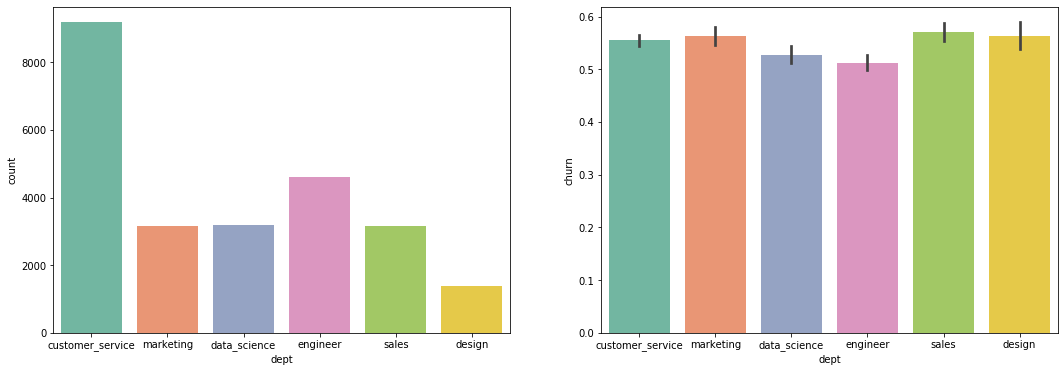

In [12]:
fig,ax = plt.subplots(1,2,figsize = (18,6))
sns.countplot(x = 'dept', data = data, ax = ax[0], palette = 'Set2')
sns.barplot(x = 'dept', y = 'churn', data = data, ax = ax[1],palette = 'Set2')

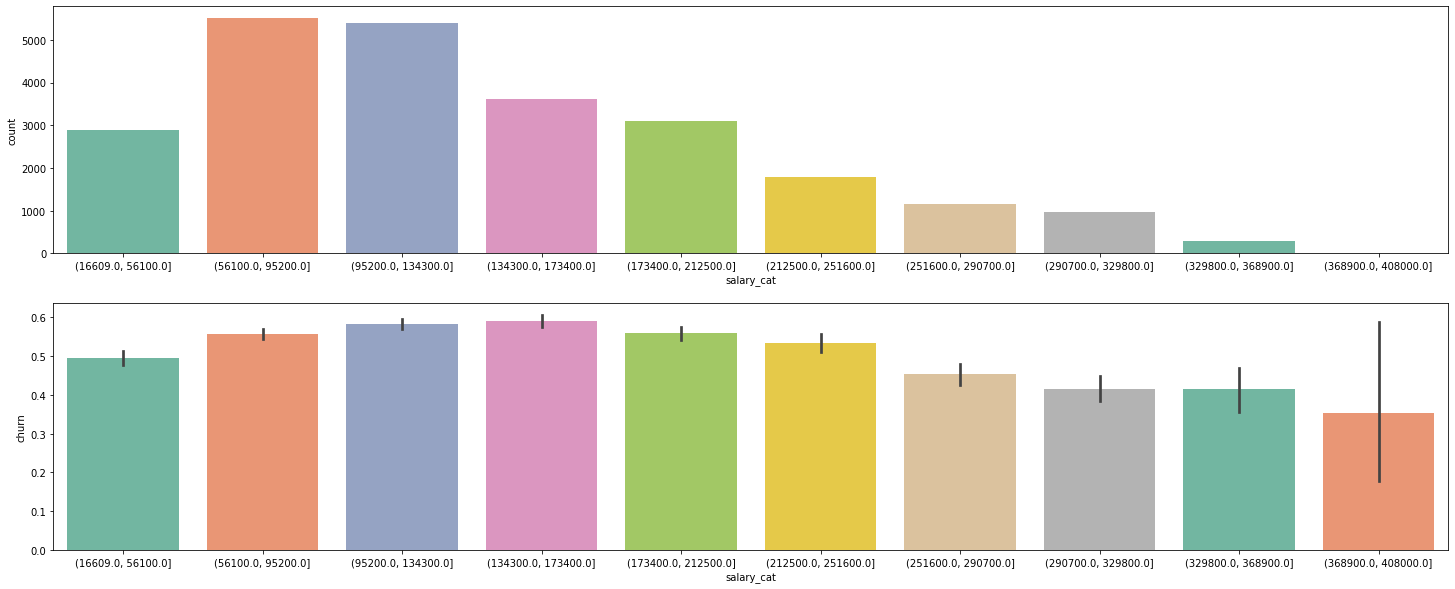

In [13]:
# binning the salary 
data['salary_cat'] = pd.cut(data['salary'], bins=10)
fig,ax = plt.subplots(2,1,figsize = (25,10))
sns.countplot(x = 'salary_cat', data = data, ax = ax[0], palette = 'Set2')
sns.barplot(x = 'salary_cat', y = 'churn', data = data, ax = ax[1],palette = 'Set2')


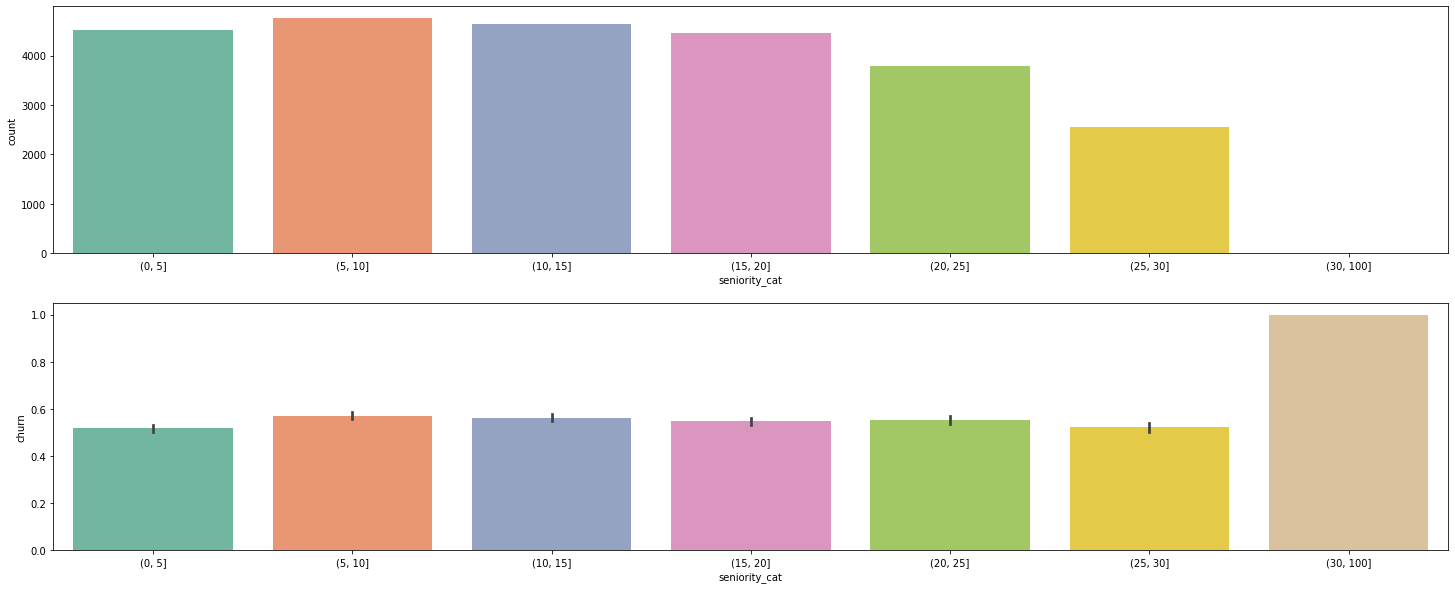

In [14]:
# binning the seniority
seniority_bins = [0,5,10,15,20,25,30,100]
data['seniority_cat'] = pd.cut(data['seniority'], bins=seniority_bins)
fig,ax = plt.subplots(2,1,figsize = (25,10))
sns.countplot(x = 'seniority_cat', data = data, ax = ax[0], palette = 'Set2')
sns.barplot(x = 'seniority_cat', y = 'churn', data = data, ax = ax[1],palette = 'Set2')

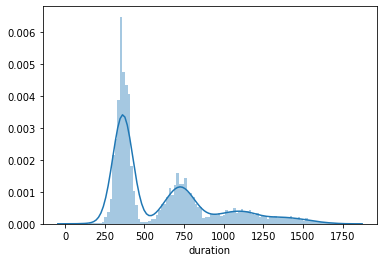

In [16]:
# observe the people who already left company
sns.distplot(data_dropna['duration'],bins = 100)

### Modelling 

In [17]:
# initiate h2o cluster
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [18]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_201"; Java(TM) SE Runtime Environment (build 1.8.0_201-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from /Users/wenxianfei/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpzri_j_15
  JVM stdout: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpzri_j_15/h2o_wenxianfei_started_from_python.out
  JVM stderr: /var/folders/gw/zmyv4gmj5m1fp4bn9549gkl00000gn/T/tmpzri_j_15/h2o_wenxianfei_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_wenxianfei_dwyjn8
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [19]:
# transform to h2o dataframe
h2o_frame = H2OFrame(data)
h2o_frame['churn'] = h2o_frame['churn'].asfactor()
h2o_frame.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,churn,salary_cat,seniority_cat
type,int,int,enum,int,int,time,time,enum,enum,enum,enum
mins,36.0,1.0,,1.0,17000.0,1295827200000.0,1318464000000.0,,,,
mean,501604.4035300784,3.426969476155781,,14.127803416727366,138183.34547809843,1372498777556.4734,1399052618327.16,,,,
maxs,999969.0,12.0,,99.0,408000.0,1449705600000.0,1449619200000.0,,,,
sigma,288909.0261007113,2.7000109677072097,,8.089519596306804,76058.18457287704,44439198685.29434,33384290754.076416,,,,
zeros,0,0,,0,0,0,0,,,,
missing,0,0,0,0,0,0,11192,0,0,0,0
0,13021.0,7.0,customer_service,28.0,89000.0,2014-03-24 00:00:00,2015-10-30 00:00:00,585 days 00:00:00,1,"(56100.0, 95200.0]","(25, 30]"
1,825355.0,7.0,marketing,20.0,183000.0,2013-04-29 00:00:00,2014-04-04 00:00:00,340 days 00:00:00,1,"(173400.0, 212500.0]","(15, 20]"
2,927315.0,4.0,marketing,14.0,101000.0,2014-10-13 00:00:00,,NaT,0,"(95200.0, 134300.0]","(10, 15]"


In [20]:
# modelling for studying the importance of every features
feature = ['company_id','dept','seniority','salary','join_date']
target = 'churn'
# build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=h2o_frame)

drf Model Build progress: |███████████████████████████████████████████████| 100%


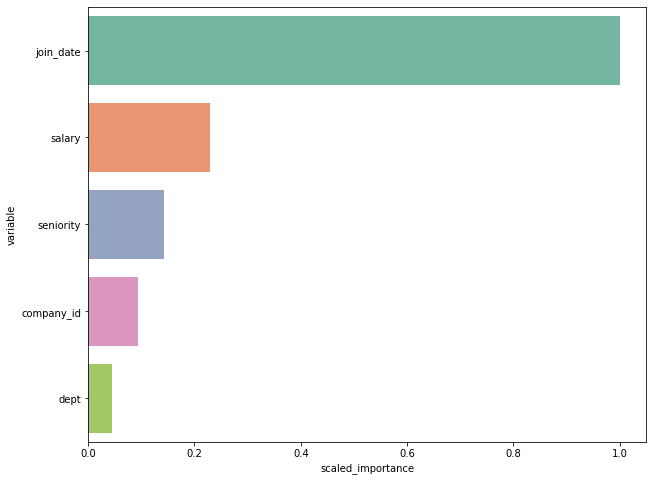

In [21]:
# observe the Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance,palette = 'Set2')
plt.show()

Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


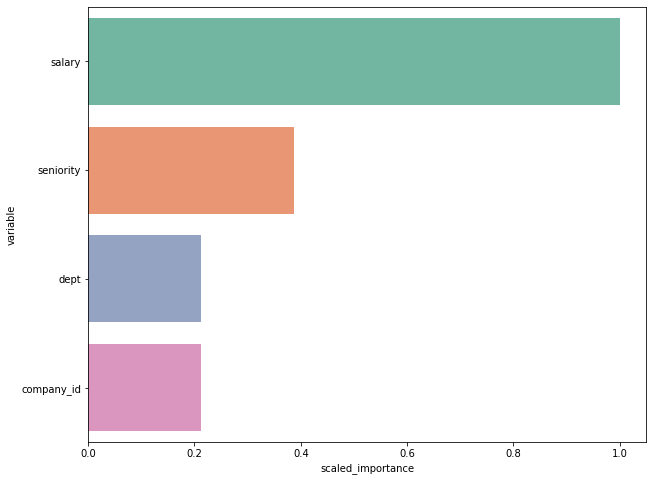

In [23]:
# if using the dataset without missing value to predict the duration period
h2o_frame_dropna = H2OFrame(data_dropna)
feature = ['company_id','dept','seniority','salary']
target = 'duration'
# build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=h2o_frame_dropna) 

# observe the Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance,palette = 'Set2')
plt.show()

### Summary

The order of important that main factors may influence employee churn is salary, seniority, department they belong to.

Also, from the above visualization, we can find that 
1. Employees churn in data science or engineering are more stable. 
2. There are 3 peaks people choose to leave company: after 1 entire year, after 2 entire year, or after 3 entire year they start their work. Especially, most people quit their job in their first year. 